In [14]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [16]:
df = pd.read_csv('features.csv')
df

,lat,lon,idle_start_hour,idle_duration_hr,week_number,cluster
0,50.902192,-114.067445,18,0.192500,1,-1
1,50.859112,-114.010217,19,0.956392,1,-1
2,50.944630,-114.127887,20,0.105003,1,0
3,50.944657,-114.128373,20,11.364719,1,0
4,51.038268,-114.140078,8,0.426942,1,-1
...,...,...,...,...,...,...
313,51.157487,-114.087725,18,1.190833,5,-1
314,50.944605,-114.128343,19,12.611667,5,0
315,51.150758,-114.109193,9,0.930000,6,-1
316,51.151242,-114.109317,10,0.155000,6,-1


In [18]:
def summarize_cluster_natural_downtime(df, cluster_col='cluster', idle_duration_col='idle_duration_hr'):
    """
    Summarizes natural downtime statistics for each cluster.
    
    Parameters:
        df (pd.DataFrame): Input DataFrame containing cluster and idle duration information.
        cluster_col (str): Column name representing cluster labels.
        idle_duration_col (str): Column name representing idle durations (in hours).
    
    Returns:
        pd.DataFrame: Summary DataFrame with total, average, frequency, and natural downtime per cluster.
    """
    df = df.copy()

    # Filter out noise clusters (typically labeled -1)
    valid_clusters = df[df[cluster_col] != -1]

    # Group and aggregate
    cluster_summary = valid_clusters.groupby(cluster_col).agg({
        idle_duration_col: ['sum', 'mean', 'count']
    }).reset_index()

    # Rename columns
    cluster_summary.columns = [cluster_col, 'total_downtime', 'avg_downtime', 'frequency']

    # Calculate natural downtime: frequency * average downtime
    cluster_summary['natural_downtime'] = cluster_summary['frequency'] * cluster_summary['avg_downtime']

    return cluster_summary

In [19]:
summary_df = summarize_cluster_natural_downtime(df, cluster_col='cluster')

# Merge natural downtime into your main DataFrame if needed
df = df.merge(summary_df[['cluster', 'natural_downtime']], on='cluster', how='left')

In [20]:
df

,lat,lon,idle_start_hour,idle_duration_hr,week_number,cluster,natural_downtime
0,50.902192,-114.067445,18,0.192500,1,-1,NaN
1,50.859112,-114.010217,19,0.956392,1,-1,NaN
2,50.944630,-114.127887,20,0.105003,1,0,621.875572
3,50.944657,-114.128373,20,11.364719,1,0,621.875572
4,51.038268,-114.140078,8,0.426942,1,-1,NaN
...,...,...,...,...,...,...,...
313,51.157487,-114.087725,18,1.190833,5,-1,NaN
314,50.944605,-114.128343,19,12.611667,5,0,621.875572
315,51.150758,-114.109193,9,0.930000,6,-1,NaN
316,51.151242,-114.109317,10,0.155000,6,-1,NaN


In [24]:
df['natural_downtime'] = df['natural_downtime'].fillna(0)
df

,lat,lon,idle_start_hour,idle_duration_hr,week_number,cluster,natural_downtime
0,50.902192,-114.067445,18,0.192500,1,-1,0.000000
1,50.859112,-114.010217,19,0.956392,1,-1,0.000000
2,50.944630,-114.127887,20,0.105003,1,0,621.875572
3,50.944657,-114.128373,20,11.364719,1,0,621.875572
4,51.038268,-114.140078,8,0.426942,1,-1,0.000000
...,...,...,...,...,...,...,...
313,51.157487,-114.087725,18,1.190833,5,-1,0.000000
314,50.944605,-114.128343,19,12.611667,5,0,621.875572
315,51.150758,-114.109193,9,0.930000,6,-1,0.000000
316,51.151242,-114.109317,10,0.155000,6,-1,0.000000


## LSTM Model Setup

In [26]:
# Define Features and Scale Data

features = ['idle_duration_hr', 'lat', 'lon', 'idle_start_hour', 'week_number', 'cluster']
target = 'natural_downtime'

# Scale
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(df[features])
y_scaled = scaler_y.fit_transform(df[[target]])


In [28]:
# Reshape Sequences for LSTM Input

sequence_length = 5
X_seq, y_seq = [], []

for i in range(len(X_scaled) - sequence_length):
    X_seq.append(X_scaled[i:i + sequence_length])
    y_seq.append(y_scaled[i + sequence_length])

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

The initial hyperparameters for this model were as such:
- epochs=20
- batch_size=32
- 

In [31]:


model = Sequential()
model.add(LSTM(64, activation='tanh', input_shape=(sequence_length, len(features))))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

# Train
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

C:\Users\omoni\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 64)                  │          18,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,241 (71.25 KB)

 Trainable params: 18,241 (71.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 0.2409 - val_loss: 0.1566
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1811 - val_loss: 0.1787
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1956 - val_loss: 0.1605
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1819 - val_loss: 0.1567
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1739 - val_loss: 0.1617
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1947 - val_loss: 0.1734
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1915 - val_loss: 0.1612
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1703 - val_loss: 0.1548
Epoch 9/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1844 - val_loss: 0.1551
Epoch 10/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2069 - val_loss: 0.1586
Epoch 11/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1941 - val_loss: 0.1591
Epoch 12/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1862 - val_loss: 0.1560
E

In [33]:
loss = model.evaluate(X_test, y_test)
print(f'Test MSE: {loss:.4f}')

# Predict and inverse transform
y_pred = model.predict(X_test)
y_pred_actual = scaler_y.inverse_transform(y_pred)
y_test_actual = scaler_y.inverse_transform(y_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.1119
Test MSE: 0.1178
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 259ms/step


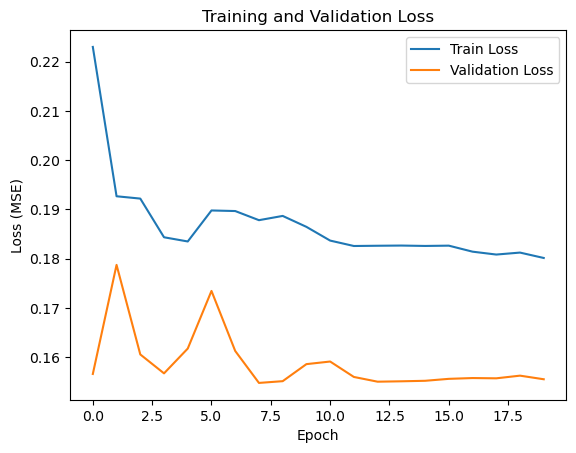

In [34]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()
